# Correlation between long-term and short-term interest rates

Task: determine the historical relationship between long- and short-term interest rates for U.S. Treasury securities.
data source: www.federalreserve.gov

In [9]:
#Importing modules and data
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

DATA=pd.read_csv("FRB_H15.csv")

In [10]:
DATA

,Series Description,"Market yield on U.S. Treasury securities at 1-year constant maturity, quoted on investment basis","Market yield on U.S. Treasury securities at 10-year constant maturity, quoted on investment basis"
0,Unit:,Percent:_Per_Year,Percent:_Per_Year
1,Multiplier:,1,1
2,Currency:,NaN,NaN
3,Unique Identifier:,H15/H15/RIFLGFCY01_N.M,H15/H15/RIFLGFCY10_N.M
4,Time Period,RIFLGFCY01_N.M,RIFLGFCY10_N.M
5,1953-04,2.36,2.83
6,1953-05,2.48,3.05
7,1953-06,2.45,3.11
8,1953-07,2.38,2.93
9,1953-08,2.28,2.95


In [11]:
DATA.drop(DATA.index[:5], inplace=True)
pd.to_datetime(DATA["Series Description"], format='%Y-%m')
DATA.set_index("Series Description", inplace=True)
DATA.columns = ["Yield,U.S.Treasury,1-year","Yield,U.S.Treasury,10-year" ]

In [12]:
DATA.dtypes

Yield,U.S.Treasury,1-year     object
Yield,U.S.Treasury,10-year    object
dtype: object

In [13]:
for i in DATA.columns:
    DATA[i]=pd.to_numeric(DATA[i])

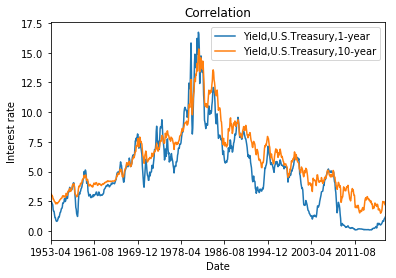

In [14]:
fig = plt.figure(figsize=(10,10))
DATA.plot()
plt.ylabel("Interest rate")
plt.xlabel("Date")
plt.title("Correlation")
plt.show()

In [15]:
Year_1=np.array(DATA["Yield,U.S.Treasury,1-year"])
Year_10=np.array(DATA["Yield,U.S.Treasury,10-year"])

Now let's check our data for correlation between lonf-term and short-term interest rates. 
Also it would be interesting to glimpse at autocorrelation.

Let's start with correlation.  

In [16]:
np.corrcoef(Year_1, Year_10)

array([[ 1.        ,  0.94705186],
       [ 0.94705186,  1.        ]])

As we can see, there is a strong correlation between short-term and long-term interest rates. 
It's evident on the graph as well.

Now let's get down to autocorrelation (dependence of the function from its previous values).
Below we defined a function to receive autocorrelation value.
Our function has 2 parameters:
x - dataset
t - period of time (default value t=5)
Below we are trying to understand how the value 5 months ago affects the current value.

In [17]:
def autocorr(x, t=5):
    coef=np.corrcoef(np.array([x[0:len(x)-t], x[t:len(x)]]))
    return coef

In [18]:
autocorr(Year_1)[0,1]

0.94647741856699885

In [19]:
autocorr(Year_10)[0,1]

0.96976593869879257

Simple Moving Average:

is calculated by taking the arithmetic mean of a given set of values. 
The sum of the prices for the past 12 months is divided by the number of months (12).

The longer out period, the smoother is the line.

Actually SMA is more applicable for days (10, 50, etc.), 
but if want to see tendencies and smooth our lines, why not to use it in our case. 

In [20]:
DATA['Moving avg. 1Y'] = DATA.iloc[:,0].rolling(window=12, min_periods=0).mean()

C:\Users\Home\Anaconda3\lib\site-packages\matplotlib\figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


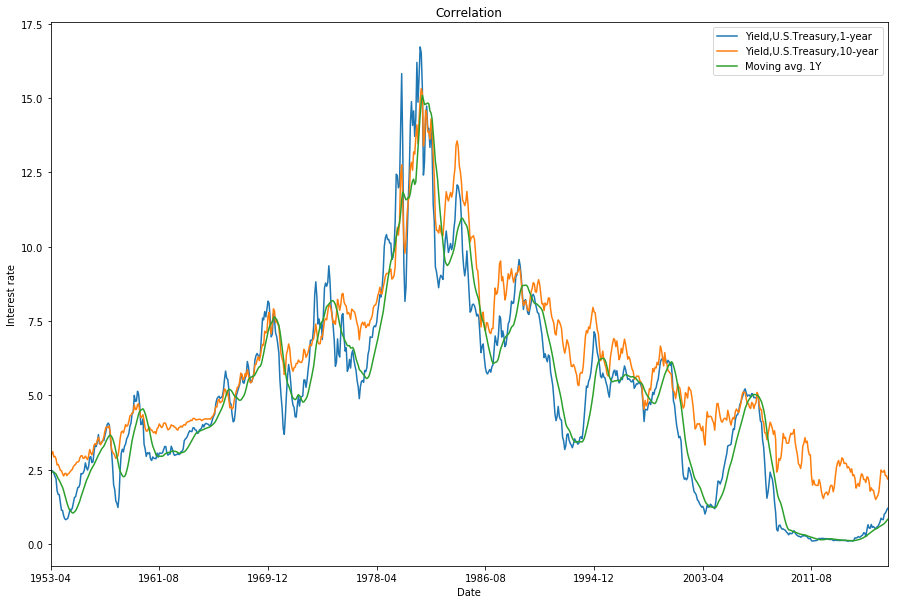

In [21]:
fig_size=[15, 10]
plt.rcParams["figure.figsize"] = fig_size
DATA.plot()
plt.ylabel("Interest rate")
plt.xlabel("Date")
plt.title("Correlation")
fig.show()

Prediction

Let's try to predict the future price for 1-Year and 10-Year U.S. bills, using Linear Regression. 

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split

X = DATA["Yield,U.S.Treasury,1-year"].shift(-5)
X.dropna(inplace = True) 
Y = DATA["Yield,U.S.Treasury,1-year"][:-5]
Y_10 = DATA["Yield,U.S.Treasury,10-year"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
lr = LinearRegression().fit(X_train.values.reshape(-1, 1), Y_train.values.reshape(-1, 1))
accuracy = lr.score(X_test.values.reshape(-1, 1), Y_test.values.reshape(-1, 1))
Y_pred = lr.predict(DATA["Yield,U.S.Treasury,1-year"][-5:].values.reshape(-1, 1))
Y_10_pred = lr.predict(Y_10[-5:].values.reshape(-1, 1))
print("Accuracy:", accuracy)

Accuracy: 0.914169298492


In [55]:
T = ["2017-07", "2017-08", "2017-09", "2017-10", "2017-11"]
DATA_pred_1 = pd.DataFrame(index=T, columns = ["Pred_1"])
DATA_pred_10 = pd.DataFrame(index=T, columns = ["Pred_10"])

a=0
for i in T:
    DATA_pred_1.loc[i] = Y_pred[a]
    DATA_pred_10.loc[i] = Y_10_pred[a]
    a+=1

C:\Users\Home\Anaconda3\lib\site-packages\matplotlib\figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


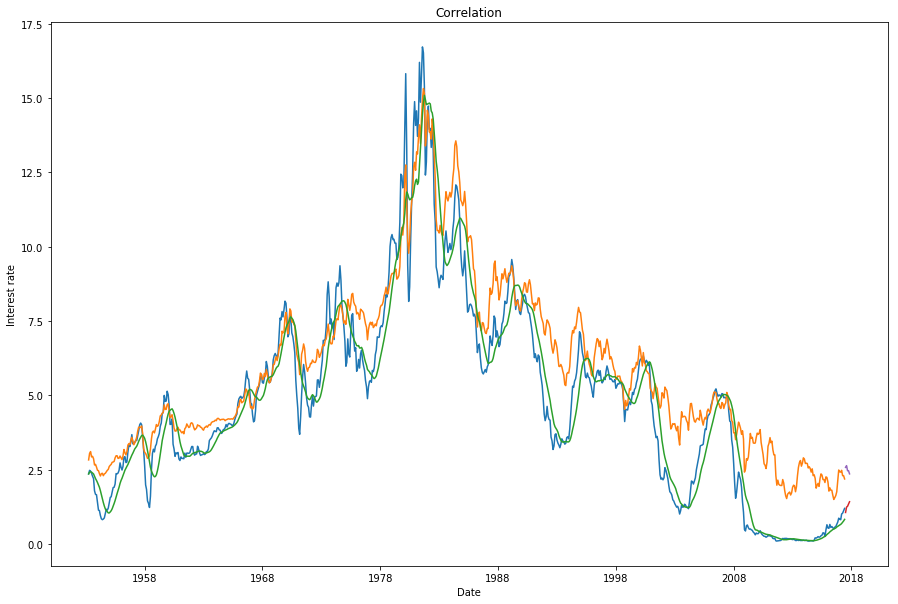

In [54]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

fig_size=[15, 10]
plt.rcParams["figure.figsize"] = fig_size
ax1.plot(DATA)
ax1.plot(DATA_pred_1)
ax1.plot(DATA_pred_10)

plt.ylabel("Interest rate")
plt.xlabel("Date")
plt.title("Correlation")
fig.show()

We see that the algorithm performed well with 1-Year bonds, and obviously has the wrong intercept for 10-Year bonds. 

It could be explained, that the algorithm was trained with the dataset for 1-Year bonds. 

We could achieve the same result for 10-Year bonds, if we retrained the algorithm. 